In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torchvision.utils import save_image

In [3]:
# MNIST 데이터셋 준비 및 DataLoader 설정
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST('./data/mnist', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.Resize(28),
                       transforms.ToTensor(),  # 데이터 [0,1]로 정규화
                       transforms.Normalize([0.5], [0.5])  # [-1, 1] 범위로 변환
                   ])),
    batch_size=64, shuffle=True)

100%|██████████| 9.91M/9.91M [00:03<00:00, 3.09MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 144kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.42MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 1.66MB/s]


In [4]:
# Generator 네트워크 정의 (생성기)
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 28*28),
            nn.Tanh()  # 출력값을 [-1, 1] 범위로 맞춤
        )

    def forward(self, z):
        return self.model(z).view(-1, 1, 28, 28)

# Discriminator 네트워크 정의 (판별기)
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()  # 최종 출력: 확률 값
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        return self.model(img_flat)


In [5]:

# 장치 설정 (GPU 사용 가능하면 GPU 사용)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 생성기와 판별기 초기화
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# 옵티마이저 설정 (Adam 사용)
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# 손실 함수: Binary Cross Entropy Loss 사용
criterion = nn.BCELoss()

# 에포크 수 설정
num_epochs = 100

# 평가를 위해 고정된 노이즈 벡터 생성 (이미지 생성 비교용)
fixed_noise = torch.randn(64, 100, device=device)

# 결과 저장을 위한 폴더 생성
os.makedirs('./images', exist_ok=True)
os.makedirs('./results', exist_ok=True)

# GAN 학습 루프 (에포크 단위)
for epoch in range(num_epochs):
    generator.train()
    discriminator.train()

    total_d_loss = 0.0
    total_g_loss = 0.0
    total_real_score = 0.0
    total_fake_score = 0.0
    num_batches = 0

    for real_images, _ in dataloader:
        num_batches += 1
        batch_size = real_images.size(0)
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # 판별기 학습
        discriminator.zero_grad()
        outputs_real = discriminator(real_images.to(device))
        d_loss_real = criterion(outputs_real, real_labels)
        real_score = outputs_real.mean().item()

        noise = torch.randn(batch_size, 100, device=device)
        fake_images = generator(noise)
        outputs_fake = discriminator(fake_images.detach())
        d_loss_fake = criterion(outputs_fake, fake_labels)
        fake_score = outputs_fake.mean().item()

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_D.step()

        # 생성기 학습 (별도의 노이즈 샘플 사용)
        generator.zero_grad()
        noise2 = torch.randn(batch_size, 100, device=device)
        fake_images2 = generator(noise2)
        outputs = discriminator(fake_images2)
        g_loss = criterion(outputs, real_labels)
        g_loss.backward()
        optimizer_G.step()

        total_d_loss += d_loss.item()
        total_g_loss += g_loss.item()
        total_real_score += real_score
        total_fake_score += fake_score

    # 에포크당 평균 값 계산 후 출력
    avg_d_loss = total_d_loss / num_batches # 판별자 손실 값
    avg_g_loss = total_g_loss / num_batches # 생성자 손실 값
    avg_real_score = total_real_score / num_batches # 실제 이미지에 대해 판별자가 출력한 평균 '진짜일 확률'
    avg_fake_score = total_fake_score / num_batches # 가짜 이미지에 대해 판별자가 출력한 평균 '진짜일 확률'

    print(f"Epoch [{epoch+1}/{num_epochs}]: d_loss={avg_d_loss:.4f}, g_loss={avg_g_loss:.4f}, "
          f"D(x)={avg_real_score:.2f}, D(G(z))={avg_fake_score:.2f}")

    # 평가 단계: 고정 노이즈를 사용해 생성된 이미지와 판별기 결과 저장
    generator.eval()
    discriminator.eval()
    with torch.no_grad():
        fake_images = generator(fixed_noise)
        save_image(fake_images, f'./images/fake_images_epoch_{epoch+1:04d}.png', normalize=True)
        discriminator_outputs = discriminator(fake_images).cpu().detach().numpy().reshape(8, 8) # 고정 노이즈의 크기가 64
        np.save(f'./results/discriminator_outputs_epoch_{epoch+1:04d}.npy', discriminator_outputs)

print('Training finished.')


Epoch [1/100]: d_loss=0.7855, g_loss=2.2619, D(x)=0.79, D(G(z))=0.32
Epoch [2/100]: d_loss=0.6049, g_loss=2.6713, D(x)=0.82, D(G(z))=0.20
Epoch [3/100]: d_loss=0.5953, g_loss=2.4355, D(x)=0.82, D(G(z))=0.18
Epoch [4/100]: d_loss=0.7096, g_loss=2.0953, D(x)=0.78, D(G(z))=0.23
Epoch [5/100]: d_loss=0.8038, g_loss=1.7897, D(x)=0.74, D(G(z))=0.26
Epoch [6/100]: d_loss=0.9047, g_loss=1.5485, D(x)=0.70, D(G(z))=0.30
Epoch [7/100]: d_loss=0.9672, g_loss=1.4086, D(x)=0.68, D(G(z))=0.32
Epoch [8/100]: d_loss=1.0144, g_loss=1.3081, D(x)=0.66, D(G(z))=0.34
Epoch [9/100]: d_loss=1.0377, g_loss=1.2684, D(x)=0.65, D(G(z))=0.35
Epoch [10/100]: d_loss=1.0509, g_loss=1.2459, D(x)=0.65, D(G(z))=0.36
Epoch [11/100]: d_loss=1.0687, g_loss=1.2152, D(x)=0.64, D(G(z))=0.36
Epoch [12/100]: d_loss=1.0969, g_loss=1.1655, D(x)=0.63, D(G(z))=0.37
Epoch [13/100]: d_loss=1.1212, g_loss=1.1233, D(x)=0.62, D(G(z))=0.38
Epoch [14/100]: d_loss=1.1302, g_loss=1.1092, D(x)=0.62, D(G(z))=0.39
Epoch [15/100]: d_loss=1.1452

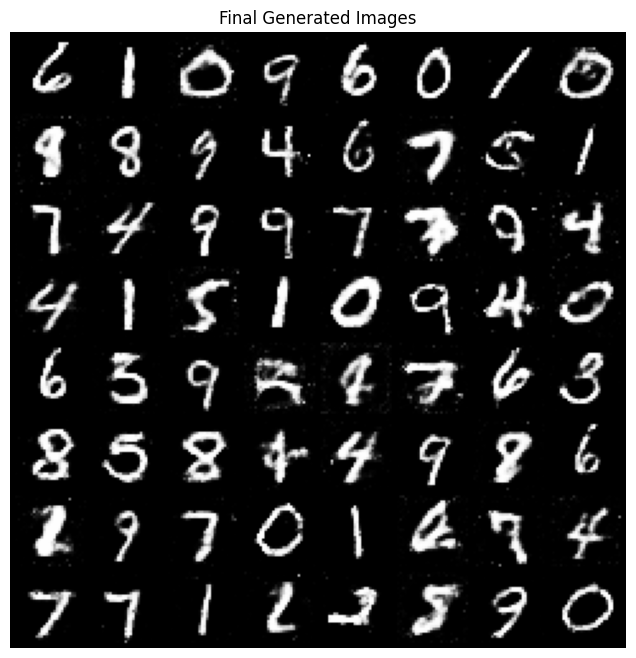

In [6]:

# 마지막 에포크에서 생성된 이미지 그리드 출력
with torch.no_grad():
    fake_images = generator(fixed_noise).detach().cpu()
grid = utils.make_grid(fake_images, nrow=8, normalize=True)
plt.figure(figsize=(8,8))
plt.imshow(np.transpose(grid, (1, 2, 0)))
plt.title('Final Generated Images')
plt.axis('off')
plt.show()
